In [1]:
import sys
sys.path.append("..")
import os
import time
import tempfile
from collections import defaultdict
RASTERIO_BEST_PRACTICES = dict(
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry

from NAIPTileIndex import NAIPTileIndex
from models import RCF, featurize

In [2]:
device = torch.device('cuda')

## Initialize model

In [3]:
num_features = 1024

model = RCF(num_features).eval().to(device)

## Read data

In [4]:
df = pd.read_csv("../data/outcomes_sampled_population_CONTUS_16_640_POP_100000_0.csv", index_col=0)
points = df[["lon", "lat"]].values
y_all = df["population"].values

## Extract features method 1

In [6]:
index = NAIPTileIndex("../tmp/")

In [9]:
buffer_distance = 250  # in meters
x_all_new = np.zeros((points.shape[0], num_features), dtype=float)

tic = time.time()
for i, (lon, lat) in enumerate(points):
    
    if i % 100 == 0:
        print(f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f} -- {time.time()-tic:0.2f} seconds")
        tic = time.time()
    
    if i % 200 == 0 and i > 0:
        break
    
    point_geom = shapely.geometry.mapping(
        shapely.geometry.Point(lon, lat)
    )
    
    fns = list(set(index.lookup_point(lat, lon)))
    fns = sorted(fns, key=lambda x: int(x.split("/")[6])) # sort by year
    
    fn = fns[-1]    
    
    with rasterio.open(fn, "r") as f:
        point_geom = rasterio.warp.transform_geom("epsg:4326", f.crs.to_string(), point_geom)
        point_shape = shapely.geometry.shape(point_geom)
        
        mask_shape = point_shape.buffer(buffer_distance).envelope
        mask_geom = shapely.geometry.mapping(mask_shape)
        
        out_image, out_transform = rasterio.mask.mask(f, [mask_geom], crop=True)
        
    features = featurize(out_image, model, device)
    x_all_new[i] = features

0/100000 -- 0.00 -- 0.00 seconds
100/100000 -- 0.10 -- 27.89 seconds
200/100000 -- 0.20 -- 27.52 seconds


## Extract features method 2

In [5]:
class CustomDataset(Dataset):

    def __init__(self, points, fns, buffer=250):
        self.points = points
        self.fns = fns
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):
        
        lon, lat = self.points[idx]
        fn = self.fns[idx]
        
        point_geom = shapely.geometry.mapping(
            shapely.geometry.Point(lon, lat)
        )
        
        with rasterio.Env():
            with rasterio.open(fn, "r") as f:
                point_geom = rasterio.warp.transform_geom("epsg:4326", f.crs.to_string(), point_geom)
                point_shape = shapely.geometry.shape(point_geom)
                mask_shape = point_shape.buffer(self.buffer).envelope
                mask_geom = shapely.geometry.mapping(mask_shape)
                out_image, out_transform = rasterio.mask.mask(f, [mask_geom], crop=True)
        
        out_image = (out_image / 255.0)
        out_image = torch.from_numpy(out_image).float()
        return out_image

In [6]:
%%time
index = NAIPTileIndex("../tmp/")
all_fns = []
for i, (lon, lat) in enumerate(points):
    point_geom = shapely.geometry.mapping(
        shapely.geometry.Point(lon, lat)
    )
    
    fns = list(set(index.lookup_point(lat, lon)))
    fns = sorted(fns, key=lambda x: int(x.split("/")[6])) # sort by year
    fn = fns[-1]    
    all_fns.append(fn)

CPU times: user 34.8 s, sys: 1.51 s, total: 36.3 s
Wall time: 36.3 s


In [7]:
buffer_distance = 300  # in meters
dataset = CustomDataset(points, all_fns, buffer=buffer_distance)

dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=8,
    collate_fn=lambda x: x,
    pin_memory=False
)

/anaconda/envs/mosaiks/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
%%time

x_all = np.zeros((points.shape[0], num_features), dtype=float)

tic = time.time()
i = 0
for images in dataloader: 
    for image in images:
        
        if image.shape[0] == 4:
            image = image.to(device)
            with torch.no_grad():
                feats = model(image.unsqueeze(0)).cpu().numpy() 
        
            x_all[i] = feats
        elif image.shape[0] == 3:
            pass # this happens in at least Nevada for some points
        
        if i % 1000 == 0:
            print(f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f} -- {time.time()-tic:0.2f} seconds")
            tic = time.time()
        i += 1

0/100000 -- 0.00 -- 4.73 seconds
1000/100000 -- 1.00 -- 46.46 seconds
2000/100000 -- 2.00 -- 46.33 seconds
3000/100000 -- 3.00 -- 46.49 seconds
4000/100000 -- 4.00 -- 45.54 seconds
5000/100000 -- 5.00 -- 45.73 seconds
6000/100000 -- 6.00 -- 46.18 seconds
7000/100000 -- 7.00 -- 45.73 seconds
8000/100000 -- 8.00 -- 45.01 seconds
9000/100000 -- 9.00 -- 45.33 seconds
10000/100000 -- 10.00 -- 45.60 seconds
11000/100000 -- 11.00 -- 45.73 seconds
12000/100000 -- 12.00 -- 45.60 seconds
13000/100000 -- 13.00 -- 45.74 seconds
14000/100000 -- 14.00 -- 45.37 seconds
15000/100000 -- 15.00 -- 46.11 seconds
16000/100000 -- 16.00 -- 45.96 seconds
17000/100000 -- 17.00 -- 45.90 seconds
18000/100000 -- 18.00 -- 45.83 seconds
19000/100000 -- 19.00 -- 45.56 seconds
20000/100000 -- 20.00 -- 45.39 seconds
21000/100000 -- 21.00 -- 45.28 seconds
22000/100000 -- 22.00 -- 46.23 seconds
23000/100000 -- 23.00 -- 45.90 seconds
24000/100000 -- 24.00 -- 45.85 seconds
25000/100000 -- 25.00 -- 45.53 seconds
26000/1000

In [9]:
x_all.shape

(100000, 1024)

In [10]:
y_all.shape

(100000,)

In [37]:
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [47]:
mask = y_all >= 0

In [48]:
y_all = y_all[mask]
x_all = x_all[mask]

In [50]:
y_all_log = np.log(y_all + 1)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all_log, test_size=0.2, random_state=0)

In [59]:
ridge_cv = RidgeCV(cv=5, alphas = np.logspace(-8,8,base=10,num=17))
ridge_cv.fit(x_train, y_train)

/anaconda/envs/mosaiks/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.06622e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/anaconda/envs/mosaiks/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.01289e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/anaconda/envs/mosaiks/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.27353e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/anaconda/envs/mosaiks/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.17896e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [60]:
ridge_cv.best_score_

0.6329977373219272

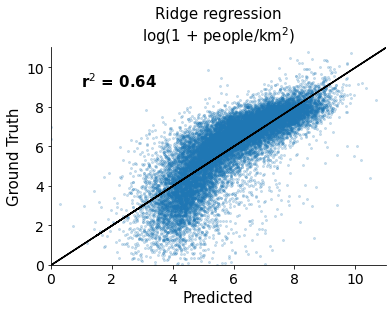

In [109]:
y_pred = np.maximum(ridge_cv.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=0.2, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.title("Ridge regression\nlog(1 + people/km$^2$)", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.plot([0,11],[0,11],color="black")

plt.xlim([0,11])
plt.ylim([0,11])

plt.text(1,9,s="r$^2$ = %0.2f" % (r2_score(y_test, y_pred)), fontsize=15, fontweight="bold")
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m*y_pred+b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()

In [85]:
from sklearn.ensemble import GradientBoostingRegressor

In [86]:
gb_model = GradientBoostingRegressor(n_estimators=100)

In [90]:
%%time
gb_model.fit(x_train, y_train)

CPU times: user 44min 18s, sys: 833 ms, total: 44min 19s
Wall time: 44min 18s


GradientBoostingRegressor()

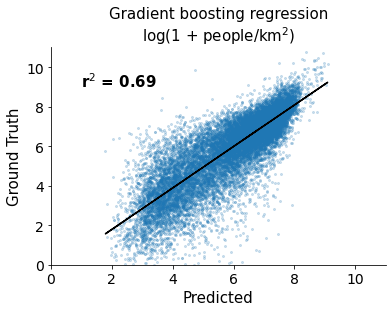

In [108]:
y_pred = np.maximum(gb_model.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=0.2, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.title("Gradient boosting regression\nlog(1 + people/km$^2$)", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0,11])
plt.ylim([0,11])

plt.text(1,9,s="r$^2$ = %0.2f" % (r2_score(y_test, y_pred)), fontsize=15, fontweight="bold")
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m*y_pred+b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()